# Stats analysis of chapter 2 - FGB

Looking at Feather Growth Bars (FGB) as a function of distance to range edge and forest cover

### Load packages

In [1]:
library(brms) # for Bayesian analysis
library(tidybayes) # for plotting bayes models
library(egg) # for nice professional figures
library(lme4) # for frequentist analysis
library(GGally) # for ggpairs
library(tidyverse) # for tidy code
library(rstan)
library(posterior)
library(cowplot)

Loading required package: Rcpp

Loading 'brms' package (version 2.19.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar



Attaching package: ‘tidybayes’


The following objects are masked from ‘package:brms’:

    dstudent_t, pstudent_t, qstudent_t, rstudent_t


Loading required package: gridExtra

Loading required package: ggplot2

Loading required package: Matrix


Attaching package: ‘lme4’


The following object is masked from ‘package:brms’:

    ngrps


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.2.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     
── Conflicts ───────────────────────────────────────

In [2]:
# check directory
getwd()

[1] "/Users/flavia/Library/CloudStorage/OneDrive-ImperialCollegeLondon/1.PHD/2.R-dir/2.chapter/2.notebook"

### Load forest cover data

In [3]:
FC <- read_csv("../2.data_cleaned/FC_calculated.csv", 
               col_types = cols(
                  species = col_character(),  # load column as character
                  bird_id = col_factor()
                    )) %>% dplyr::select(-"X0")

#### Make sure that all NAs in column percentage of FC are zeros
The function used to calculate FC in the previous script would give NAs if the landscape metric 'proportion of class' (3 for FC in MAPBIOMAS) was innexistent. That means that forest cover was innexistent, therefore NA = 0%. That happened often for smaller buffer radius like 100 m.  

In [4]:
FC$FC_percentage.value[is.na(FC$FC_percentage.value)] <- 0

### Load distance to range edge data

In [5]:
dist <- read_csv("../2.data_cleaned/NHM-MZUSP_dist2edge_data.csv")%>%
  dplyr::select(-c("in_costal_margin","feather_tail", "distance", "sex")) %>% # remove unnecessary columns
  filter(inrange == TRUE, source == "MZUSP") # keep only specimens inside the range
    

Rows: 662 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): species, subspecies, bird_id, location, sex, feather_tail, source
dbl (6): date_collected, lon_dd, lat_dd, distance, distance_sgn, dist_km
lgl (2): inrange, in_costal_margin

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Load FGB data

Load the FGB data. 

Growth bar length was measured from the pictures taken at the museum (MZUSP, Brazil) using the TPSdig software, where length is the distance from the beginning of a dark band to the end of its adjacent light band. Pictures were taken of each specimen outermost right tail feather. 

The average of the length of bars of a single feather was calculated and it is presented in the dataframe loaded below (under column "mean_fgb"; the total numbers of bars per feather is shown in column "n_bars").

In [6]:
# load feather growth bar data
FGB <-read_csv("../2.data_cleaned/fgb_width/MZUSP_fgb_mean_per_individual.csv", 
               col_types = cols(
                  species = col_character(),
                  bird_id = col_factor(),
                  mean_fgb = col_double(),
                  n_bars = col_double()
                ))

In [7]:
glimpse(FGB)

Rows: 342
Columns: 4
$ species  <chr> "A_leucophthalmus", "A_leucophthalmus", "A_leucophthalmus", "…
$ bird_id  <fct> 66941, 75569, 75596, 75631, 75697, 79904, 79963, 81707, 81717…
$ mean_fgb <dbl> 176.5231, 199.7688, 214.8527, 127.2994, 142.6025, 127.4633, 1…
$ n_bars   <dbl> 6, 6, 5, 4, 2, 10, 6, 7, 6, 4, 7, 7, 5, 7, 6, 7, 6, 3, 8, 6, …


In [8]:
print(paste(n_distinct(FGB$bird_id), "specimens out of", n_distinct(FGB$species), "species"))

print(paste("mean FGB from", FGB %>% pull(mean_fgb) %>% range()))


[1] "342 specimens out of 20 species"
[1] "mean FGB from 68.5859065207314" "mean FGB from 233.256368520402"


### Manipulate FGB data for analysis

Join FGB dataset to the distances dataset.

In [9]:
FGB_data <- dist %>% dplyr::left_join(FGB, by="bird_id")%>% # join dataset by bird_id
                dplyr::select(-"species.y")%>% # remove column created from joining FGB dataset to dist dataset
                filter(!is.na(mean_fgb))%>% # remove rows with NAs in fgb
                rename(species = species.x) # rename column created from joining FGB dataset to dist dataset
                
print(paste(n_distinct(FGB_data$bird_id), "specimens out of", n_distinct(FGB_data$species), "species"))
print(paste("mean FGB from", FGB %>% pull(mean_fgb) %>% range()))


[1] "324 specimens out of 20 species"
[1] "mean FGB from 68.5859065207314" "mean FGB from 233.256368520402"


After the join, 18 individuals show no mean_fgb value. This is because the left_join function keeps all bird IDs present in the "x" dataset (i.e dist), removing data only present in the "y" dataset (i.e FGB). That means that the function below "anti_join" can show us which individuals were removed. These individuals were > 100km outside their bird range, therefore were excluded from the analysis in a previous step (in script "05_calculate_dist_to_range_edge.R").

In [10]:
anti_join(FGB, dist, by="bird_id")

species,bird_id,mean_fgb,n_bars
<chr>,<fct>,<dbl>,<dbl>
C_speciosum,88293,190.1351,3
C_speciosum,90264,150.4016,8
C_speciosum,90265,148.6608,5
L_amaurocephalus,100606,136.8206,6
L_rufaxilla,65135,138.1883,3
L_verreauxi,65131,175.8427,6
L_verreauxi,71792,185.3405,3
L_verreauxi,93126,151.4183,6
M_auricularis,79943,117.8479,5


Now join the FGB and forest cover (FC) data set.

In [11]:
FGB_FC_data <- FGB_data %>% 
                dplyr::left_join(FC)
    
names(FGB_FC_data)

table(FGB_FC_data$source)

print(paste(n_distinct(FGB_FC_data$bird_id), "specimens out of", n_distinct(FGB_FC_data$species), "species"))

Joining with `by = join_by(species, bird_id, lon_dd, lat_dd, dist_km)`


[1] "species"             "subspecies"          "date_collected"     
 [4] "bird_id"             "lon_dd"              "lat_dd"             
 [7] "location"            "source"              "inrange"            
[10] "distance_sgn"        "dist_km"             "mean_fgb"           
[13] "n_bars"              "decade"              "biome"              
[16] "geometry"            "file_name"           "FC_buffer"          
[19] "FC_percentage.value"


MZUSP 
 3306 

[1] "324 specimens out of 20 species"


### Inspect FGB data

Look at the histogram of FGB. 

I standardised the "mean_fgb" with the function "scale" (mean=0 and sd=1) for model fitting.

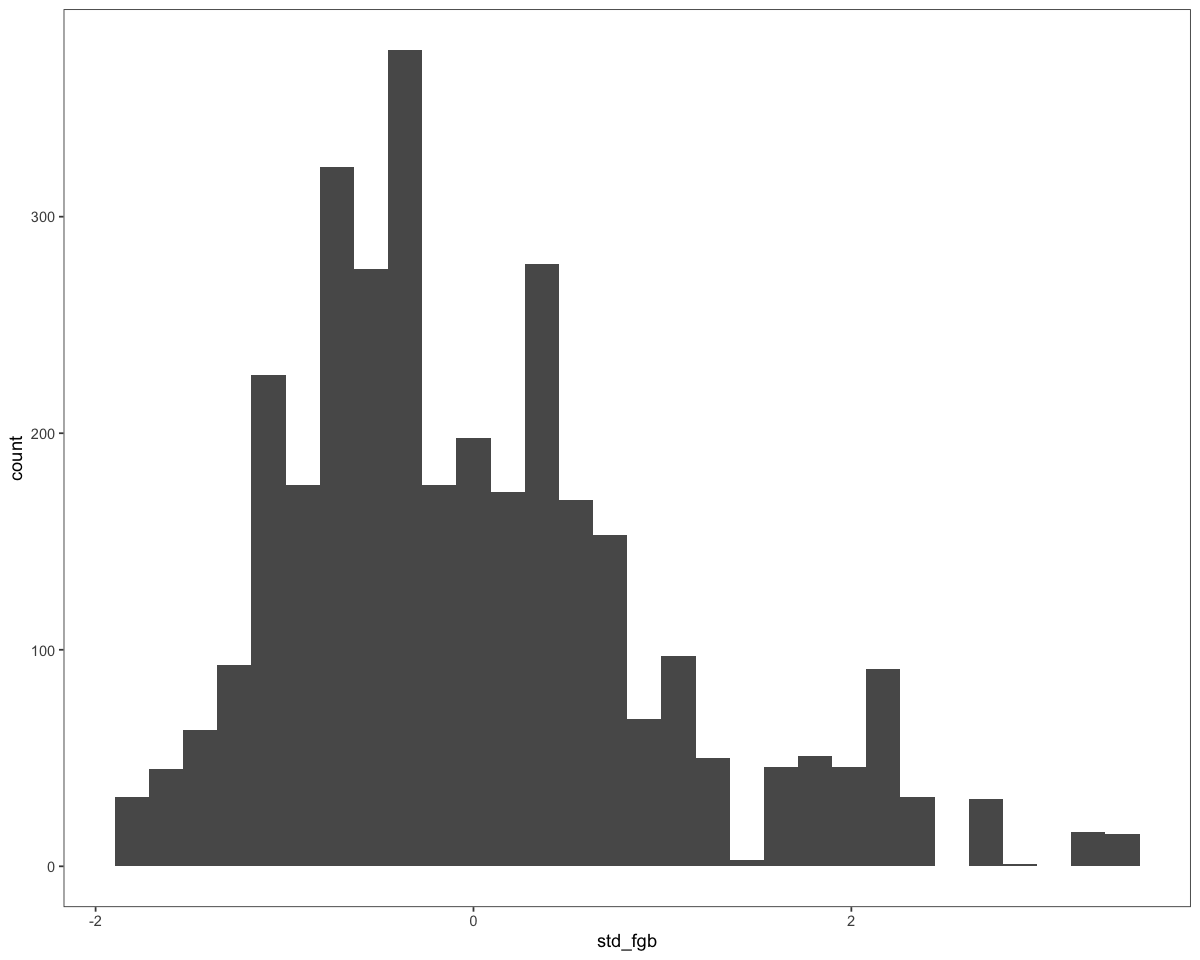

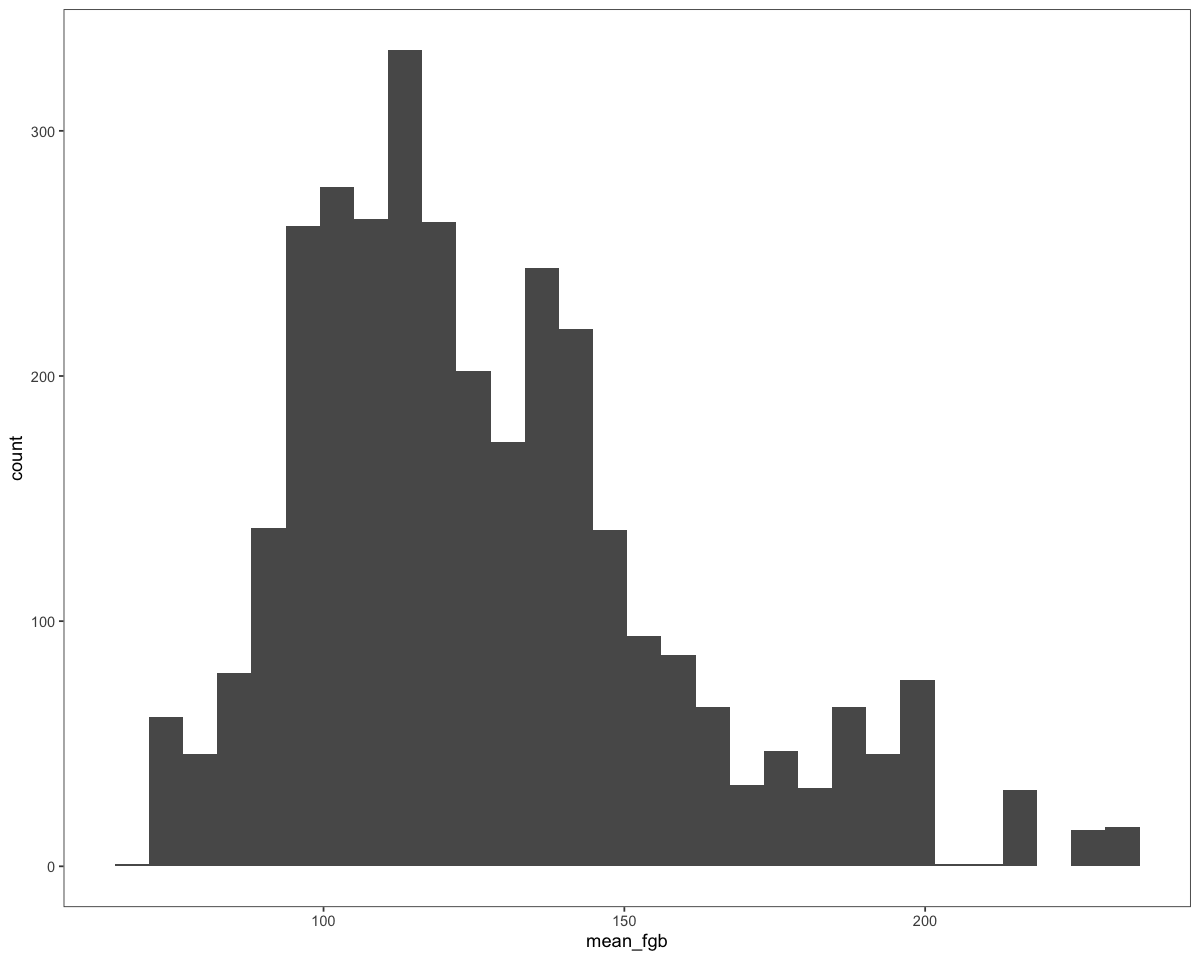

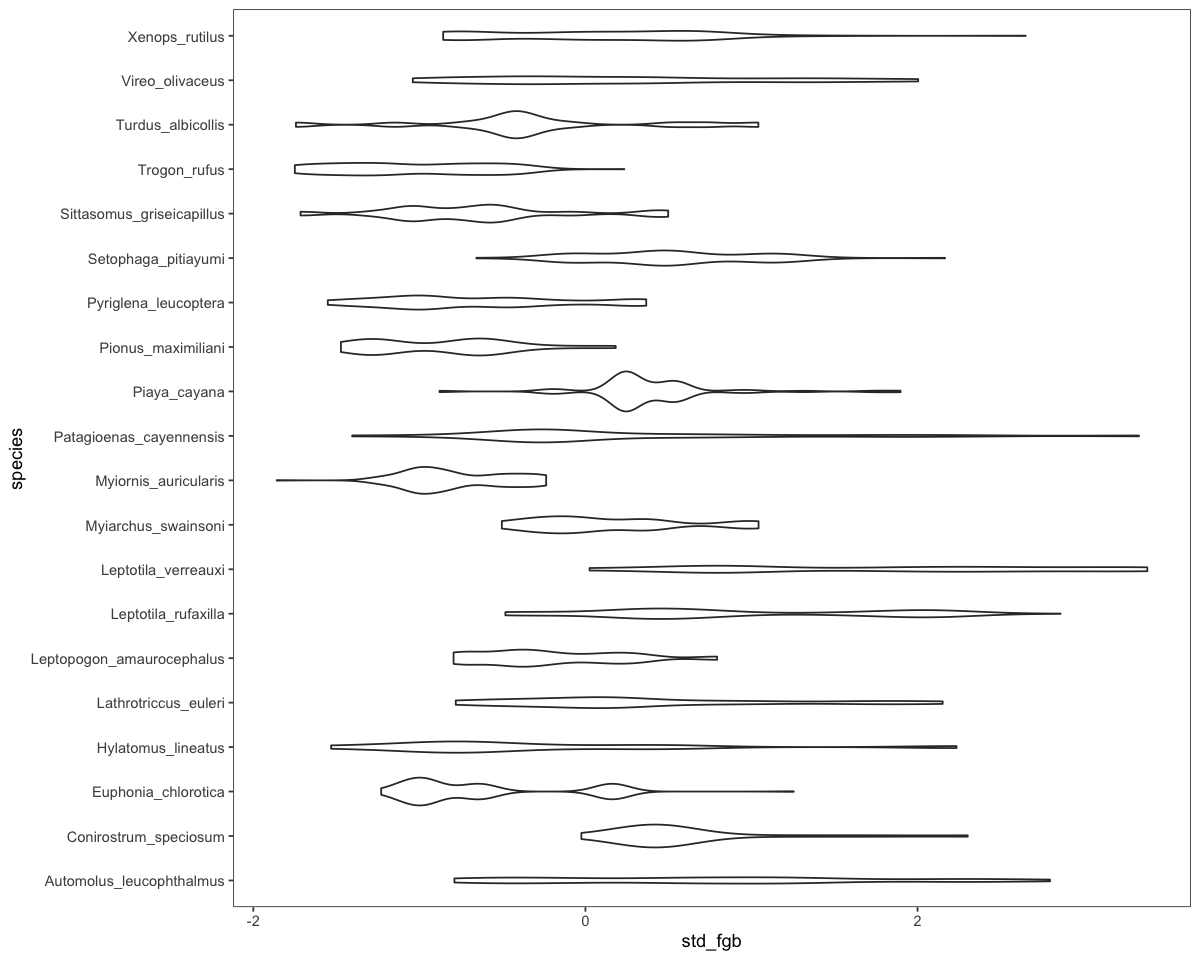

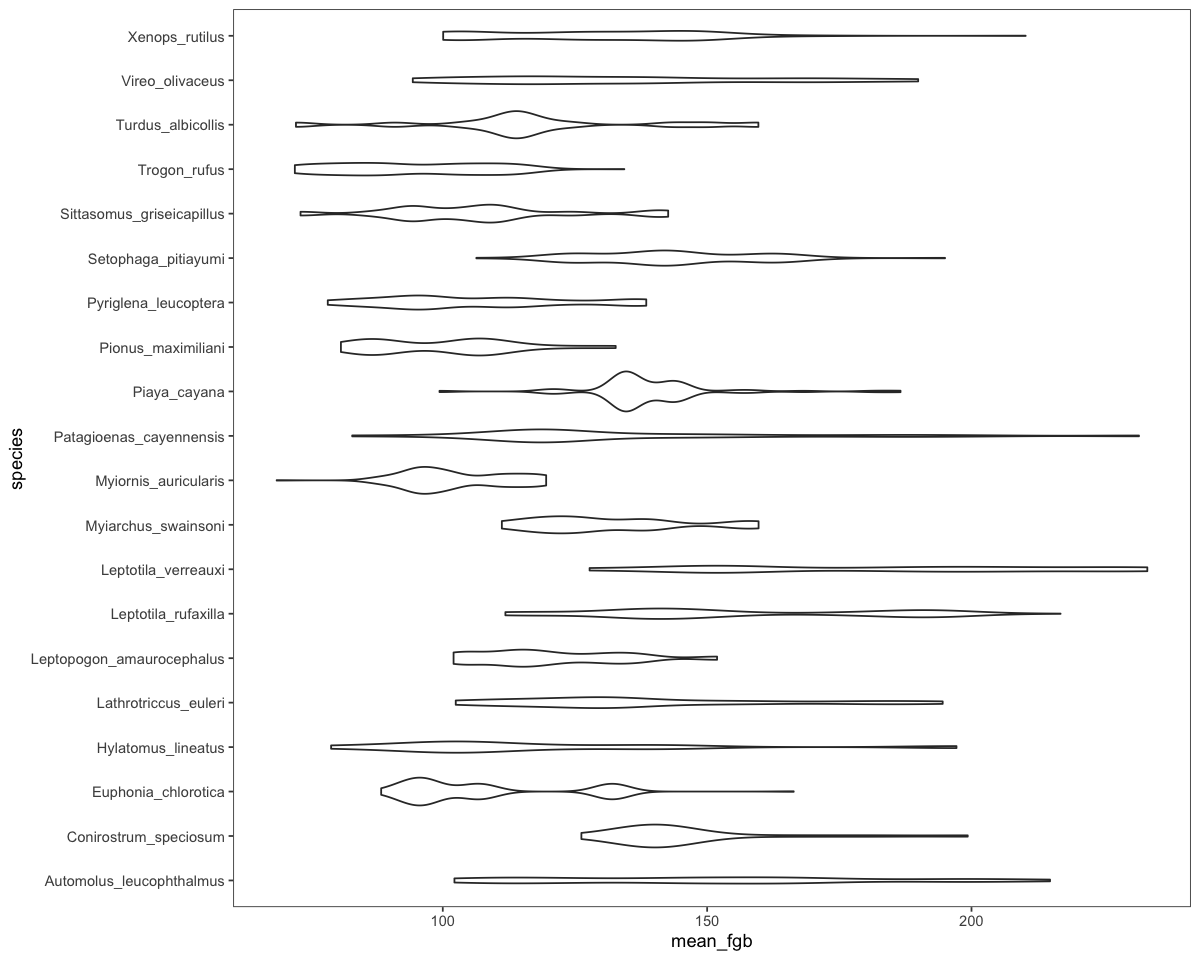

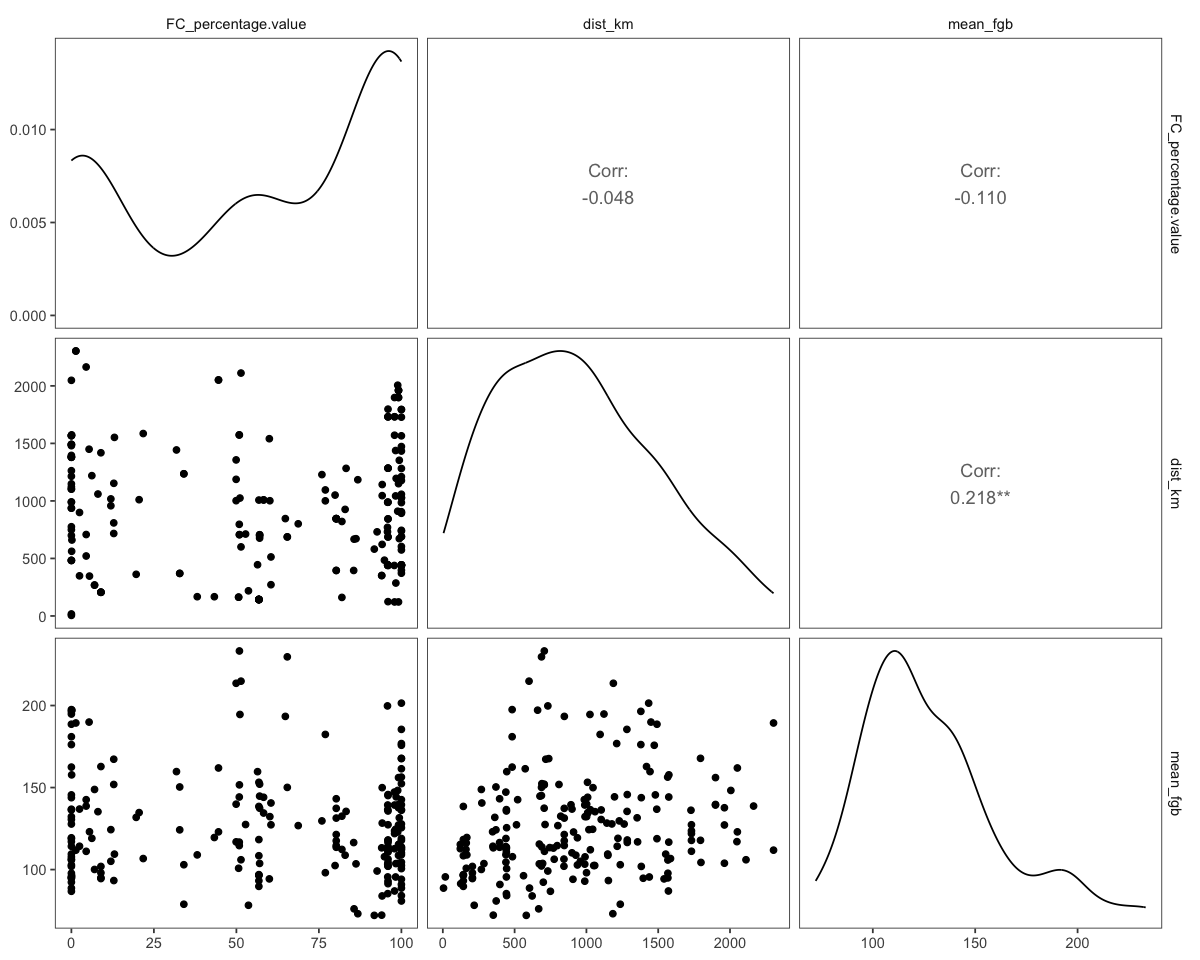

In [12]:
options(repr.plot.width=10, repr.plot.height=8)

FGB_FC_data = FGB_FC_data %>%
                mutate(std_fgb = as.vector(scale(mean_fgb)))        
# z standardise mean_fgb for model fitting purposes

plot_hist <- ggplot(FGB_FC_data, aes(x=std_fgb)) + 
              geom_histogram(bins = 30) +
                theme_article()
plot_hist
ggsave("../2.results/plots/SI/FGB_hist.png", plot_hist, width = 7, height=7, units="in")

plot_hist2 <- ggplot(FGB_FC_data, aes(x=mean_fgb)) + 
              geom_histogram(bins = 30) +
                theme_article()
plot_hist2

##
plot_violin <- ggplot(FGB_FC_data, aes(x=std_fgb, y=species)) + 
                geom_violin() +
                theme_article()
plot_violin
ggsave("../2.results/plots/SI/FGB_per_species.png", plot_violin, width = 7, height=8, units="in")

plot_violin2 <- ggplot(FGB_FC_data, aes(x=mean_fgb, y=species)) + 
                geom_violin() +
                theme_article()
plot_violin2

##
plot_pairs <- FGB_FC_data %>%
                filter(FC_buffer == 600) %>%
                ggpairs(data=. ,columns = c('FC_percentage.value', 'dist_km', 'mean_fgb'))+
                theme_article()


ggsave("../2.results/plots/SI/FGB_FC_600_dist.png", plot_pairs, width = 7, height=7, units="in")
plot_pairs

`geom_smooth()` using formula = 'y ~ x'


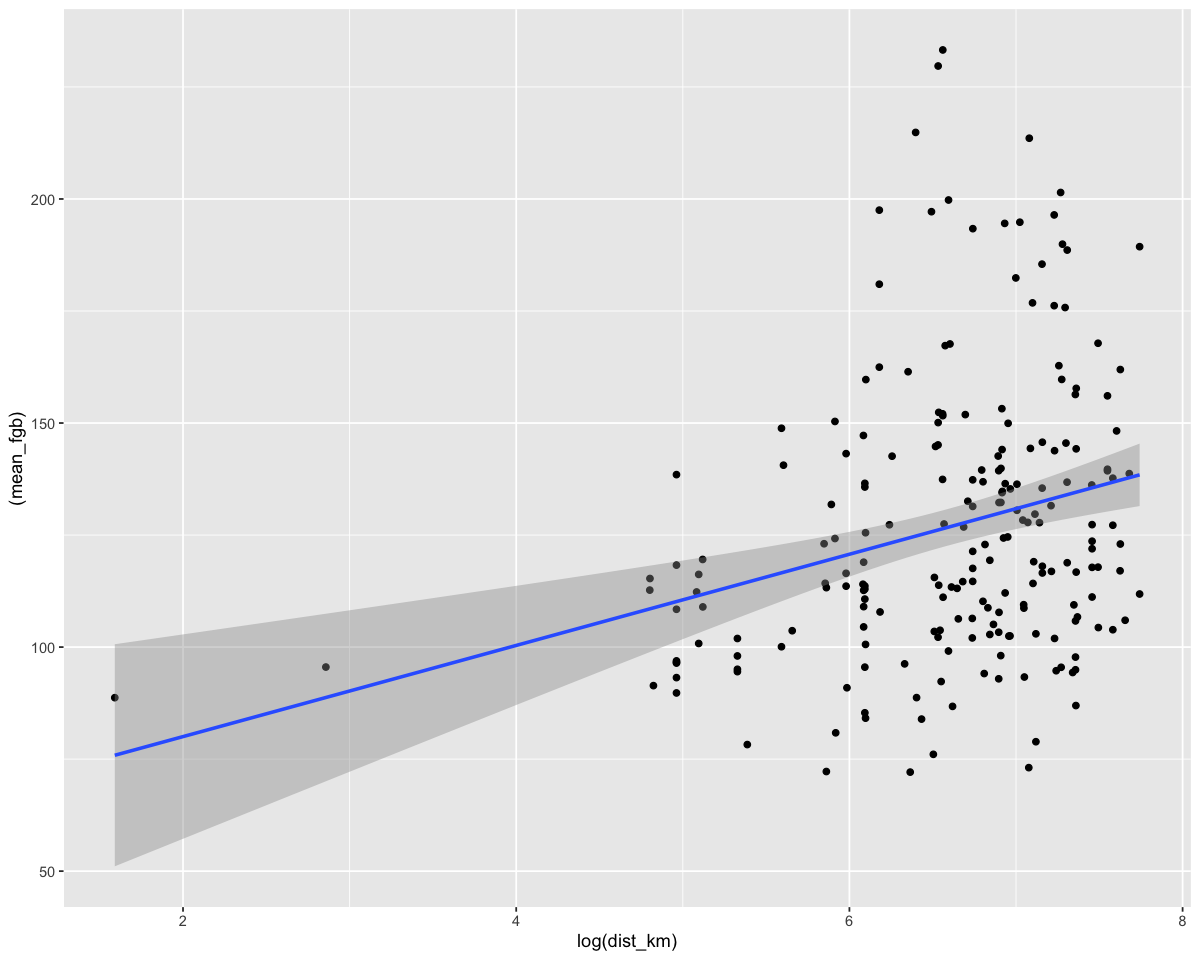

In [13]:
FGB_FC_data %>%
    filter(FC_buffer == 600) %>%
    ggplot(aes(x = log(dist_km), y = (mean_fgb)))+
        geom_point()+
        geom_smooth(method= 'lm')

## Model Fitting

Fit a model predicting feather growth bar length as a function of distance to range edge plus a random effect of species on distance and forest cover. I use standardised mean of fgb, proportion of forest cover and log of distance to range edge to avoid problems with model convergence due to variable values being too different in magnitude. 

**Questions:** 

Q.7 Does the mean FGB length decrease with a unit increase in distance to range edge?

Q.8 Does the mean FGB length decrease with a unit increase in proportion of forest cover?

Q.9 Does the mean FGB length decrease with a unit increase in the interaction between forest cover and distance to range edge?

Below I save the final data to be used for the model.

In [13]:
FGB_FC_data <- FGB_FC_data %>%
    mutate(FC_proportion = FC_percentage.value/100, #add columns
        log_dist = log(dist_km)) %>%  #add columns
    filter(!is.na(FC_buffer))

FGB_FC_data %>%
        write_csv("../2.data_model/FGB_FC_final.csv")

In [14]:
names(FGB_FC_data)

[1] "species"             "subspecies"          "date_collected"     
 [4] "bird_id"             "lon_dd"              "lat_dd"             
 [7] "location"            "source"              "inrange"            
[10] "distance_sgn"        "dist_km"             "mean_fgb"           
[13] "n_bars"              "decade"              "biome"              
[16] "geometry"            "file_name"           "FC_buffer"          
[19] "FC_percentage.value" "std_fgb"             "FC_proportion"      
[22] "log_dist"

### Bayesian models for FGB

Formula used is ```brm(bf(fgb ~ FC_proportion * log(dist_km) + (FC_proportion * log(dist_km)| species))```. It models the mean response of the standardised FGB with an interaction of proportion of forest cover amd log of distance to the range edge as a fixed/constant effect and a random effect consistent of a random intercept for species and the interaction of forest cover and distance to range edge as random slope.

Using brms default priors  = weakly informative.

First, I ran a model for **each of the buffer radius** (100 to 1500 in 100m increments) and saved them as a list of models. After inspection of models results I will choose the buffer that will be use for the analysis.

I have commented out the model below because it takes some time (~1 hour) to run, the output is saved as ```bayesmodels_buffers_FGB_randef``` in the results folder (```"../2.results/bayesmodels_buffers_FGB_randef.RData"```).

In [29]:
## fit models - I run this using a script directly in the terminal for faster fitting ("09_model_fitting_FGB.R")

# set.seed(1)

# models <- list()

# #get buffers vectors
# # buffers <- unique(FGB_FC_data$FC_buffer)
# # i=1 # test
# # buffers <- 600 # test
# #loop over buffers and fit all models
# k = 1
# for(i in buffers){
#     print(paste(i, k))
#     models[[paste(i)]] <- FGB_FC_data %>% 
#     filter(FC_buffer == i) %>% 
#     brm(bf(mean_fgb ~ FC_proportion * log(dist_km) + (log(dist_km)| species)),
#         data = .,
#         family = gaussian,
#         cores = 4, chains = 4, 
#         iter = 10000, 
#         control=list(adapt_delta = 0.99),
#         silent = 2)
#     # k <- k+1
                
# }

# #save output


#### Choosing forest cover radius

Now load models that were run directly in terminal for faster fitting (using script "09_model_fitting_FGB.R"), same code as commented out above.

In [15]:
# Load FGB bayes models and check global environment
load("../2.results/bayesmodels_buffers_FGB_randef.RData")
ls()

[1] "dist"         "FC"           "FGB"          "FGB_data"     "FGB_FC_data" 
 [6] "models"       "plot_hist"    "plot_hist2"   "plot_pairs"   "plot_violin" 
[11] "plot_violin2"

In [16]:
summary(models)

     Length Class   Mode
100  22     brmsfit list
200  22     brmsfit list
300  22     brmsfit list
400  22     brmsfit list
500  22     brmsfit list
600  22     brmsfit list
700  22     brmsfit list
800  22     brmsfit list
900  22     brmsfit list
1000 22     brmsfit list
1100 22     brmsfit list
1200 22     brmsfit list
1300 22     brmsfit list
1400 22     brmsfit list
1500 22     brmsfit list

#### Plot density and variance of forest cover per radius

Plot figures to decide which forest cover buffer radius to use for the final analysis. 
This is the density of forest cover per radius.

pdf 
  2

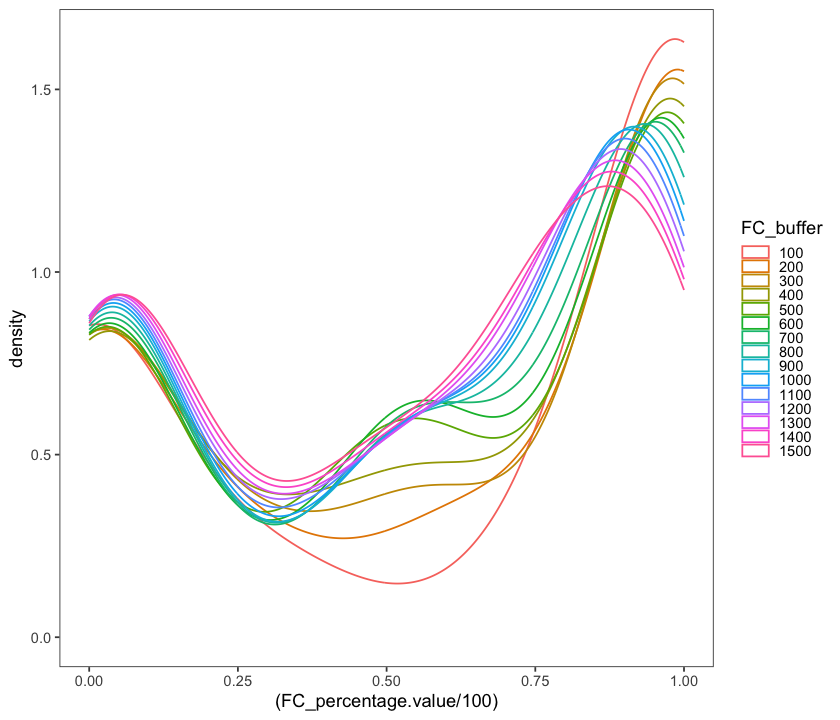

In [17]:
options(repr.plot.width=7, repr.plot.height=6)

density_FC <- FGB_FC_data %>%
        mutate(FC_buffer = as.factor(FC_buffer)) %>%
           ggplot(aes(x=(FC_percentage.value/100), color=FC_buffer))+
            geom_density() +
            theme_article()

density_FC
png(file="../2.results/plots/SI/FGB_FC_by_radius_density.png", width=7, height = 10, units="in", res = 1200)
plot(density_FC)
dev.off()

Below is the variance in proportion of forest cover plot per radius.

pdf 
  2

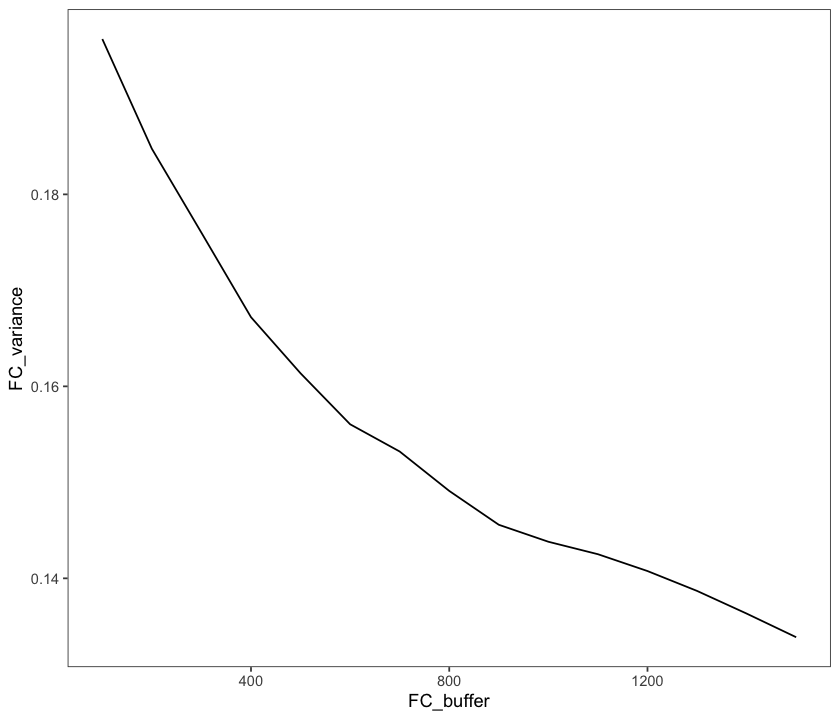

In [18]:
variance_FC = FGB_FC_data %>%
    mutate(FC_proportion = FC_percentage.value/100)%>%
    group_by(FC_buffer) %>%
    summarise(FC_variance = var(FC_proportion))%>%
       ggplot(aes(x=FC_buffer, y=FC_variance))+
        geom_line()+
        theme_article()

variance_FC
png(file="../2.results/plots/SI/FGB_FC_variance_by_radius.png", width=7, height = 10, units="in", res = 1200)
plot(variance_FC)
dev.off()

#### Plot model coefs for all buffer radius

Here I write a function to extract the coefficients of each model and get their summary statistics. The function ```gather_draws``` allows me to choose which coefficients to extract in a long-format data frame (for wide-format use ```spread_draws```). Then ```summarise_draws``` calculates all summary statistics for the coefficients selected in the step above. 

PS: If needed, the function ```get_variables()``` returns the names of variables that can be extracted from the bayes models to be passed into other functions.

In [19]:
extract_coefs = function(models_list){
    
    mean_coefs = list() # create empty list to store values
    
    for(model in 1:length(models_list)){
        
        mean_coefs[[model]] = models[[model]]%>% # store values in the list created above
            gather_draws(b_Intercept,b_FC_proportion, # choose coeffs
                         b_logdist_km,`b_FC_proportion:logdist_km`)%>%
            summarise_draws(.) %>% # calculate summary stats
            mutate(mod = names(models_list)[model], .before=".variable") # create new column 
            # with models names so I can id them later
    }
   
    return(bind_rows(mean_coefs)) # bind lists created into a dataframe and return it
    
}

Now use the function to extract the coefficients.

In [20]:
FGB_FC_mod = extract_coefs(models)

Here I had to do some data wrangling to facilitate plotting. First I transform ```buffer``` into numeric. And then rename all the coefs variable names to something less "model-like". 

In [21]:
FGB_FC_mod_buffers = FGB_FC_mod %>%
                        mutate(buffer = as.numeric(mod))%>%
                        mutate(.variable = case_when(.variable == "b_FC_proportion"~ "Forest cover proportion",
                                                     .variable == "b_FC_proportion:logdist_km" ~ "Interaction",
                                                     .variable == "b_Intercept" ~ "Intercept",
                                                     .variable == "b_logdist_km" ~ "Distance to edge log (km)")) 

In [22]:
head(FGB_FC_mod_buffers, n= 4)

mod,.variable,variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail,buffer
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,Forest cover proportion,.value,3.456803,3.382869,40.764951,40.642384,-63.777881,70.456856,1.0001074,15235.25,14540.84,100
100,Interaction,.value,-1.285981,-1.262518,6.059872,6.054987,-11.221801,8.703803,1.0001494,15086.84,14390.25,100
100,Intercept,.value,119.195468,118.376660,28.218812,27.769192,74.000537,166.890937,0.9999974,11354.40,15304.52,100
100,Distance to edge log (km),.value,1.424592,1.530863,4.230020,4.164438,-5.657799,8.238840,1.0001397,11307.12,15070.67,100


Now, finally plot it!

I discarded models with rhats greater than 1.01 as they do not have reliable estimates. I used ```facet_grid``` to plot it all at once. 

pdf 
  2

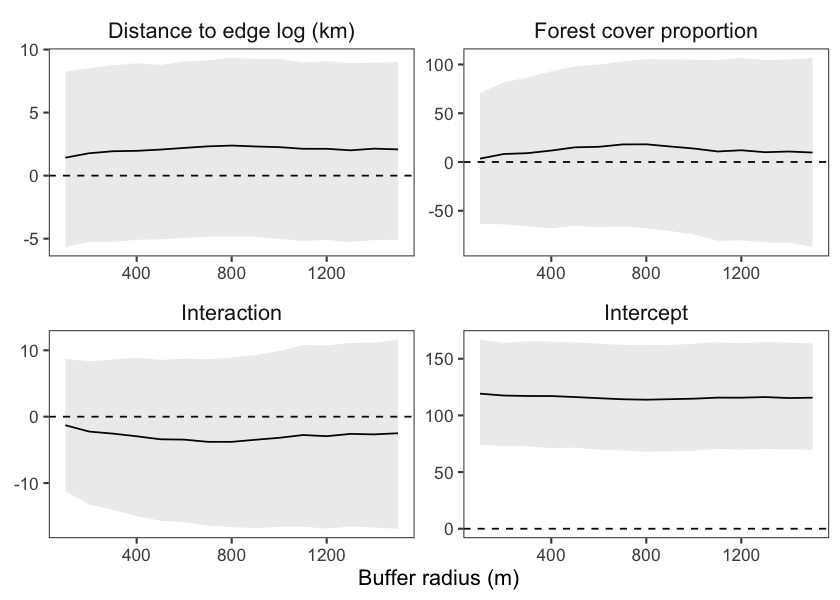

In [23]:
options(repr.plot.width=7, repr.plot.height=5)

FC_mod_coefs = FGB_FC_mod_buffers %>%
    filter(rhat < 1.01)%>%
       ggplot(aes(x=buffer, y=mean))+
        geom_line()+
        geom_hline(yintercept = 0, linetype = "dashed")+
        geom_ribbon(aes(ymin=q5, ymax=q95), alpha = 0.1)+
        labs(x = "Buffer radius (m)", y=NULL)+
        facet_wrap( ~ .variable , scales="free")+
        theme_article(base_size=13) +
        theme(strip.text = element_text(size = 13))

FC_mod_coefs
png(file="../2.results/plots/SI/FGB_FC_all_mod_coefs.png", width=7, height = 10, units="in", res = 1200)
plot(FC_mod_coefs)
dev.off()

The figure shows that FGB is not sensitive to the different buffer radius, as they are pretty much straight lines. Therefore I will use the 600 meters radius for the following reasons: 1) These species have relatively restricted movement (approx. 150m - [ref.](https://www.sciencedirect.com/science/article/pii/S253006441830066X)); 2) This scale has been used by other studies conducted with these species( [ref.](https://www.science.org/doi/10.1126/science.1255768), [ref.](https://bioone.org/journals/the-wilson-journal-of-ornithology/volume-119/issue-2/05-133.1/EDGE-RESPONSES-OF-TROPICAL-AND-TEMPERATE-BIRDS/10.1676/05-133.1.short), [ref.](https://www.nature.com/articles/s41559-019-0889-z#ref-CR18) and my first chapter); 3) All models converged at this buffers radius. 

Below I assign the respective model at 600m buffer radius from the list of models generated previously.  

In [24]:
bay_mod_FGB = models[[6]]


One last look at the data to see if there are any inconsistencies:

In [26]:
# look at total number of species
FGB_FC_data %>%
distinct(species)%>%
nrow()

# look at total number of locations
FGB_FC_data %>%
distinct(location)%>%
nrow()

# look at range of years of collection
FGB_FC_data %>%
pull(date_collected)%>%
range()

[1] 20

[1] 101

[1] 1985 2017

### FGB model results

Let's look at the summary of the model.

In [27]:
summary(bay_mod_FGB)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: mean_fgb ~ FC_proportion * log(dist_km) + (FC_proportion * log(dist_km) | species) 
   Data: . (Number of observations: 213) 
  Draws: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 20000

Group-Level Effects: 
~species (Number of levels: 20) 
                                            Estimate Est.Error l-95% CI
sd(Intercept)                                  18.11     10.11     1.24
sd(FC_proportion)                               9.99      7.91     0.37
sd(logdist_km)                                  2.43      1.49     0.13
sd(FC_proportion:logdist_km)                    1.64      1.31     0.06
cor(Intercept,FC_proportion)                   -0.07      0.44    -0.83
cor(Intercept,logdist_km)                      -0.11      0.45    -0.85
cor(FC_proportion,logdist_km)                  -0.04      0.44    -0.82
cor(Intercept,FC_proportion:logdist_km)        -0.04      0.43 

pdf 
  2

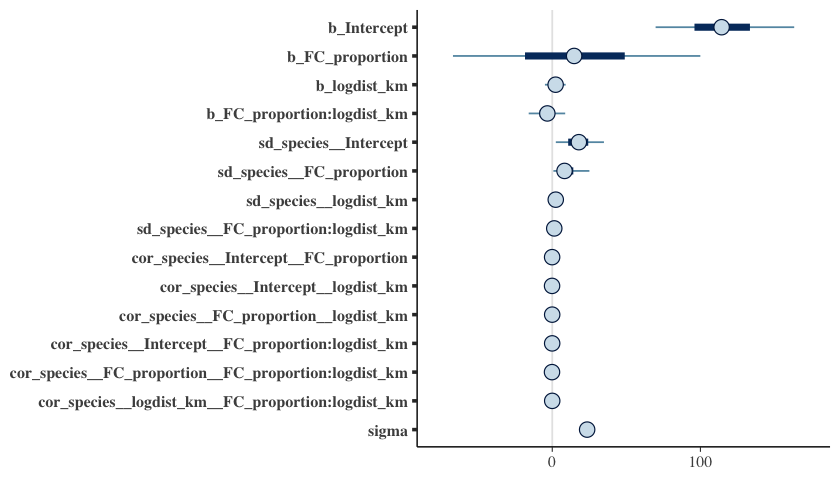

In [28]:
options(repr.plot.width=7, repr.plot.height=4)
mcmc_plot(bay_mod_FGB)

png(file="../2.results/plots/SI/FGB_bayes_coef.png", width=7, height = 10, units="in", res = 1200)
mcmc_plot(bay_mod_FGB)
dev.off()

In [57]:
FC_n = 0.9 # [0.1 to 1]
dist_n = 11 # [1.59 to 7.74]
FGB = (-0.27) + (0.51*FC_n) + (0.06*dist_n) + (-0.11*FC_n*dist_n)
print(FGB) 

# for FC = 0.1 and dist = 5, FGB is 0.026
# for FC = 0.1 and dist = 8, FA is 0.173
# for FC = 0.1 and dist = 11, FA is 0.32

# for dist = 5 and FC = 0.1, FA is 0.026
# for dist = 5 and FC = 0.5, FA is 0.01
# for dist = 5 and FC = 0.9, FA is -0.006

# for dist = 5 and FC = 0.1, FA is 0.026
# for dist = 8 and FC = 0.5, FA is 0.025
# for dist = 11 and FC = 0.9, FA is -0.24


[1] -0.24


## FIX THE TEXT HERE ##

It is okay to have a few divergent transitions as long as the Rhat is 1.00

Looking at the **population level effects**, the results suggest that feather growth bar length increases in average with an increase in proportion of forest cover (est = 0.51; CI = -2.78:3.79), but it decreases as well as with an increase in distance to the range edge (est = 0.06; CI = -0.24:0.32). If FC is held constant and dist increases, FGB length increases at a faster rate than if dist is held constant and FC increases. Therefore changes in distance have a stronger impact in wing FA than changes in FC. The interaction between FC and dist is zero. However, the confidence intervals around the explanatory variable estimates span zero, therefore there is a chance lower than 95% that FA respond to these variables in this manner. Nonetheless, it is possible to calculate the probability to which we expect these estatements are true, by using the ```hypothesis function``` below. 

The **group-level effects** revels negative correlations between the intercept and slopes for species, meaning that species with large "baseline level of variability" (i.e. with a large variation in FA value) tend to show less variability with increasing distance to the range edge.The standard deviation indicates that between species there is variation in their response to the population level effects (Intercept est = 0.89; CI = 0.13:2.21) and FC is an important driver of variation between species (FC est = 0.42; CI = 0.01:1.26). 

Hypothesis Tests for class b:
    Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio Post.Prob Star
1     Distance     2.20      4.25    -4.94     9.04       2.40      0.71     
2 Forest_cover    15.59     50.79   -67.02    99.95       1.60      0.62     
3  Interaction    -3.45      7.52   -15.90     8.73       2.06      0.67     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

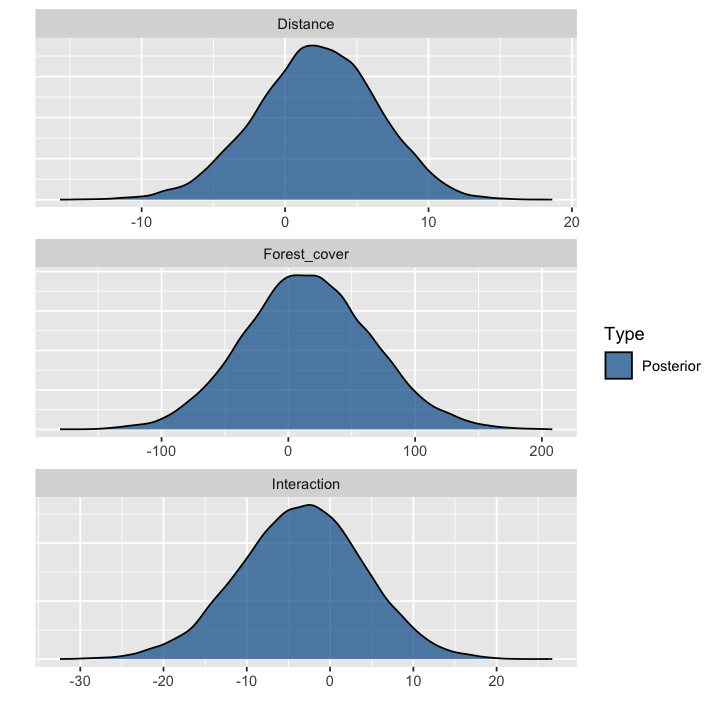

In [30]:
options(repr.plot.width=6, repr.plot.height=6)

# Q.7: Does variance in FGB for wing increase with a unit increase in distance to range edge?
Q7 = c(Distance = "logdist_km > 0 ")

# Q.8: Does variance in FGB for wing increase with a unit increase in proportion of forest cover?
Q8 = c(Forest_cover = "FC_proportion > 0 ")

# Q.9: Does variance in FGB for wing increase with a unit increase in the interaction between forest cover and distance to range edge?
Q9 = c(Interaction = "FC_proportion:logdist_km < 0 ")

hypothesis(bay_mod_FGB, c(Q7, Q8, Q9))

plot(hypothesis(bay_mod_FGB, c(Q7, Q8, Q9)))

**Q.7: Does FGB length increase with a unit increase in distance to range edge?**
 
A1: 

**Q.8: Does FGB length increase with a unit increase in proportion of forest cover?**

A2: 

**Q.9: Does FGB length increase with a unit increase in the interaction between forest cover and distance to range edge?**
 
A3: 

### Plot model results

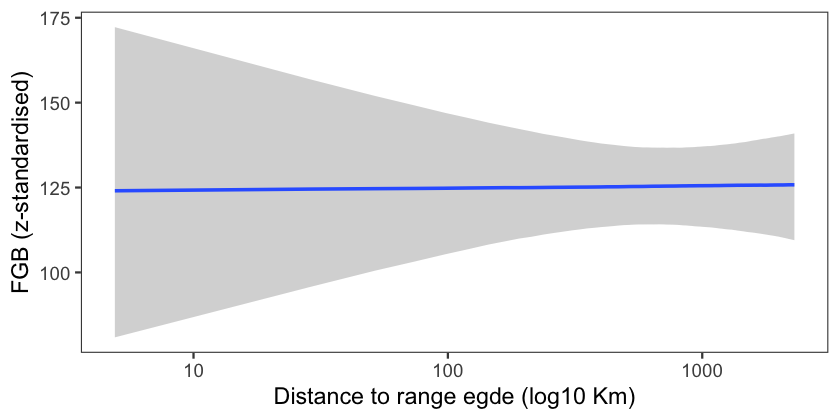

In [32]:
# FGB ~ distance to range edge
options(repr.plot.width=7, repr.plot.height=3.5)

cond_eff <- conditional_effects(bay_mod_FGB, effects = "dist_km")
p_t = plot(cond_eff, plot = FALSE)

p = p_t[['dist_km']] + 
    scale_x_continuous(trans = 'log10')+
    labs(x = "Distance to range egde (log10 Km)", y = "FGB (z-standardised)")+
    theme_article(base_size = 14)+
    theme(legend.position = "none")

p

ggsave("../2.results/plots/SI/FGB_DE.png", plot = p, 
      width = 7, height = 3.5, units = "in")

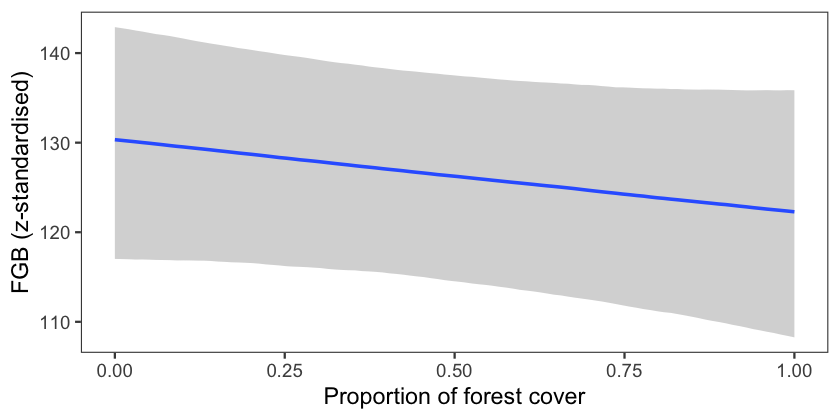

In [33]:
# FGB ~ Forest cover
options(repr.plot.width=7, repr.plot.height=3.5)

cond_eff <- conditional_effects(bay_mod_FGB, effects = "FC_proportion")
p_t = plot(cond_eff, plot = FALSE)

p = p_t[['FC_proportion']] + 
    #scale_x_continuous(trans = 'log10')+
    labs(x = "Proportion of forest cover", y = "FGB (z-standardised)")+
    theme_article(base_size = 14)+
    theme(legend.position = "none")

p

ggsave("../2.results/plots/SI/FGB_FC.png", plot = p, 
      width = 7, height = 3.5, units = "in")

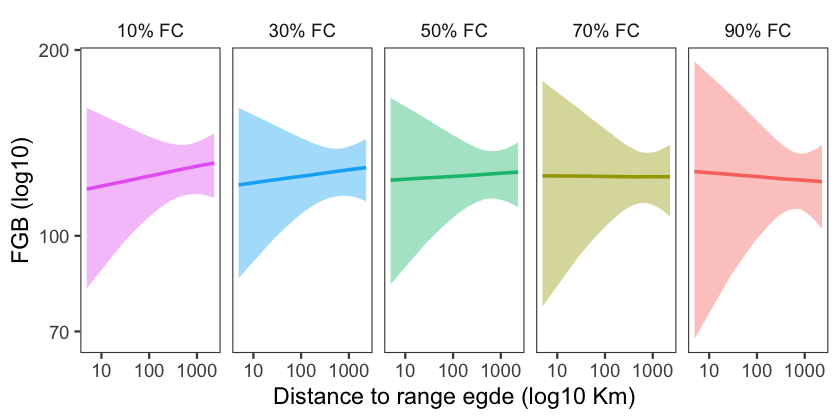

In [34]:
# FGB ~ interaction
options(repr.plot.width=7, repr.plot.height=3.5)

int_conditions <- list(
FC_proportion = setNames(c(0.1, 0.3, 0.5, 0.7, 0.9), c("10% FC", "30% FC", "50% FC", "70% FC", "90% FC"))
)

cond_eff <- conditional_effects(bay_mod_FGB, effects = "dist_km:FC_proportion", int_conditions=int_conditions)
p_t = plot(cond_eff, plot = FALSE)

# New facet label names for dose variable
FClabs <- c("10% FC", "30% FC", "50% FC", "70% FC", "90% FC")
names(FClabs) <- c(0.1, 0.3, 0.5, 0.7, 0.9)

p = p_t[['dist_km:FC_proportion']] + 
    facet_grid(.~FC_proportion, labeller = labeller(FC_proportion=FClabs))+
    scale_y_continuous(trans = 'log10')+
    scale_x_continuous(trans = 'log10')+
    labs(x = "Distance to range egde (log10 Km)", y = "FGB (log10)")+
    theme_article(base_size = 14)+
    theme(legend.position = "none")

p

ggsave("../2.results/plots/main_text/FGB_interaction.png", plot = p, 
      width = 7, height = 3.5, units = "in")

### Model performance checks

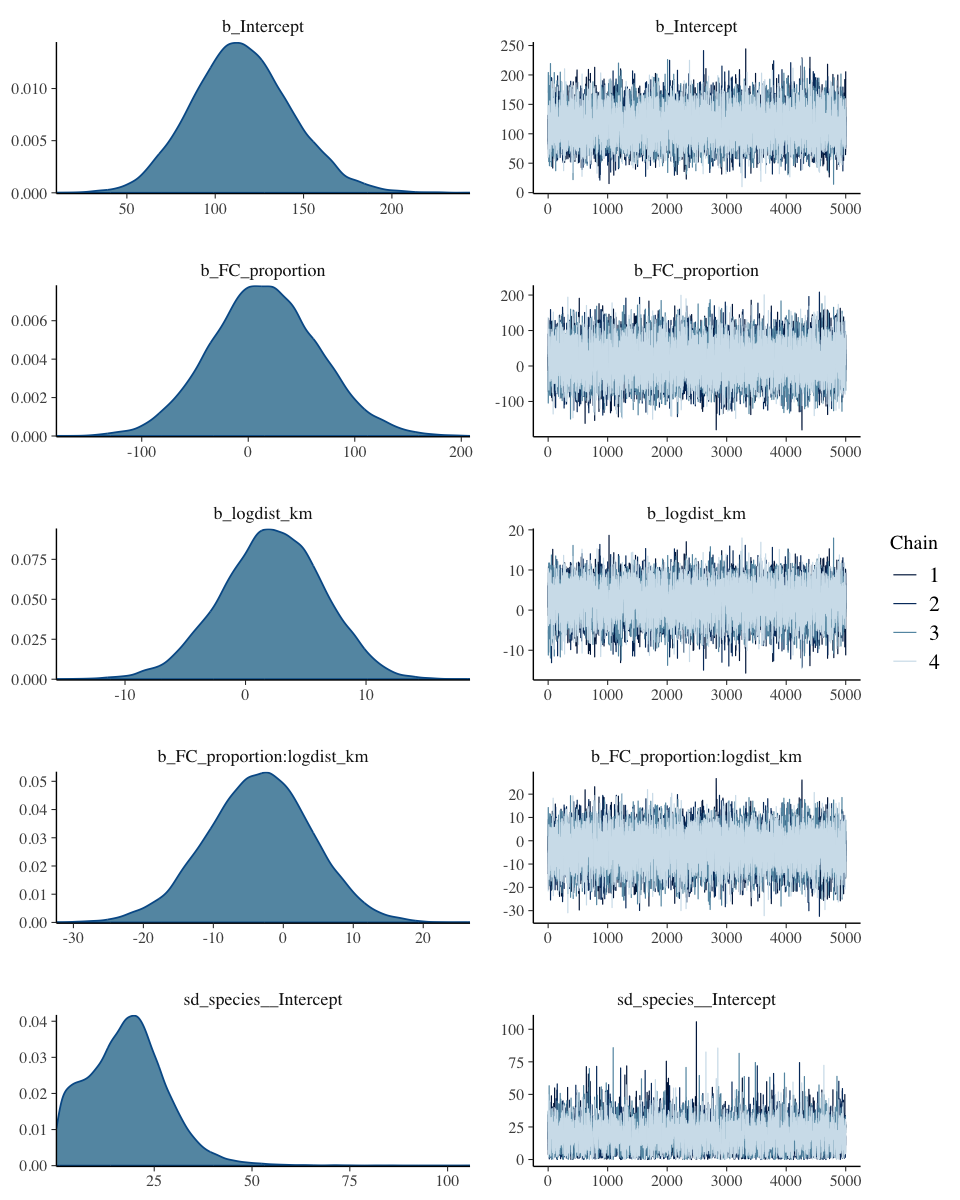

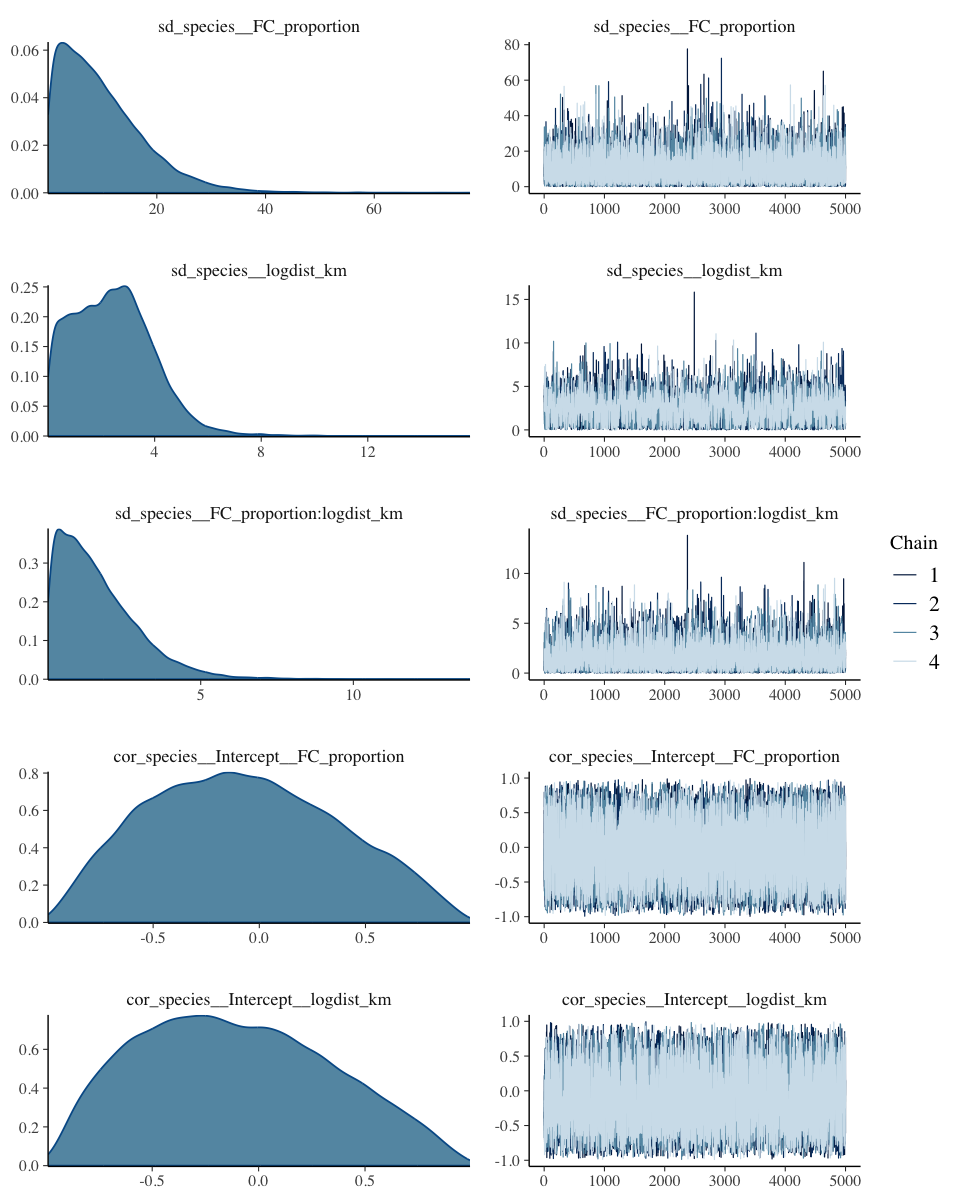

pdf 
  2

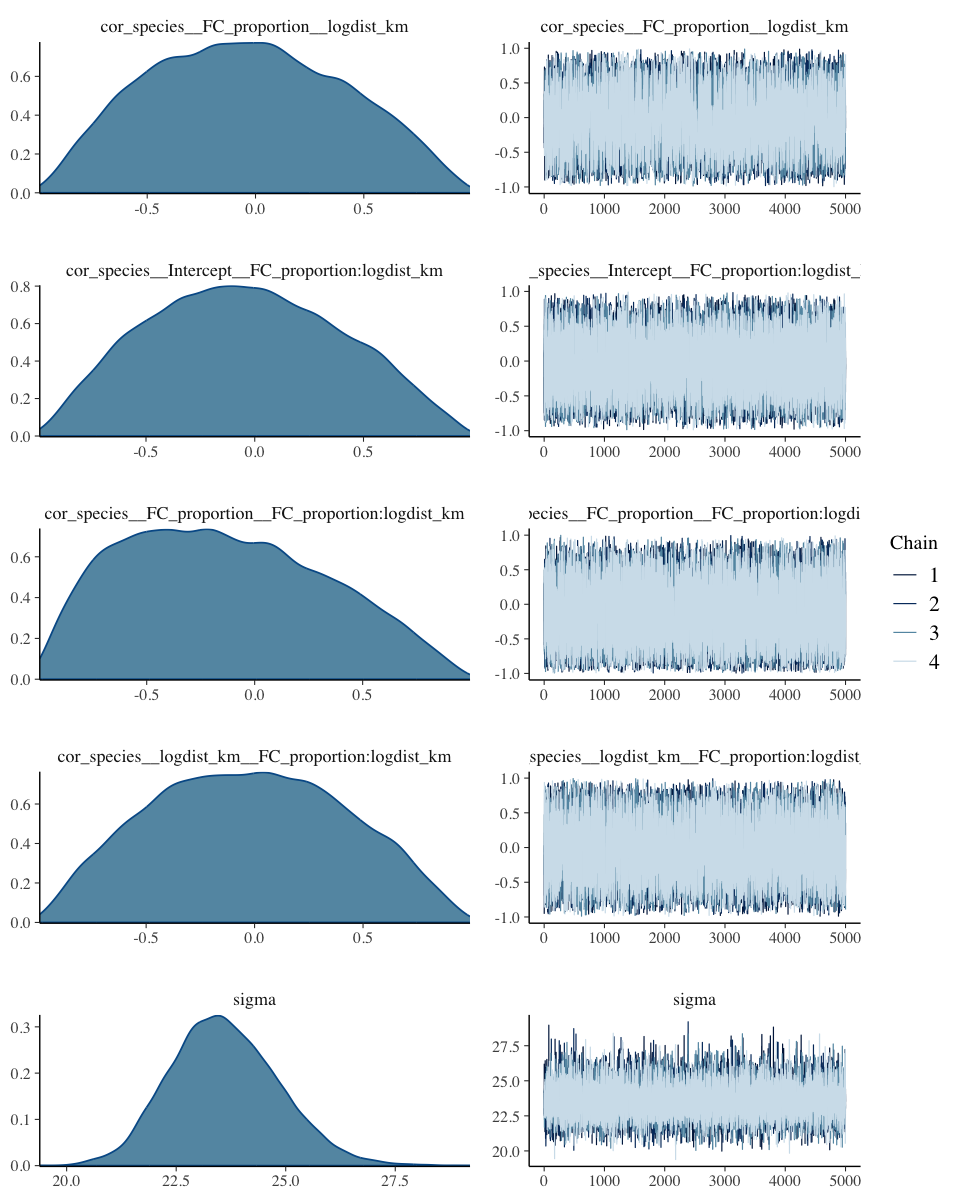

In [35]:
options(repr.plot.width=8, repr.plot.height=10)
plot(bay_mod_FGB)

png(file="../2.results/plots/SI/FGB_bayes_coefs_chains.png", width=7, height = 10, units="in", res = 1200)
plot(bay_mod_FGB)
dev.off()


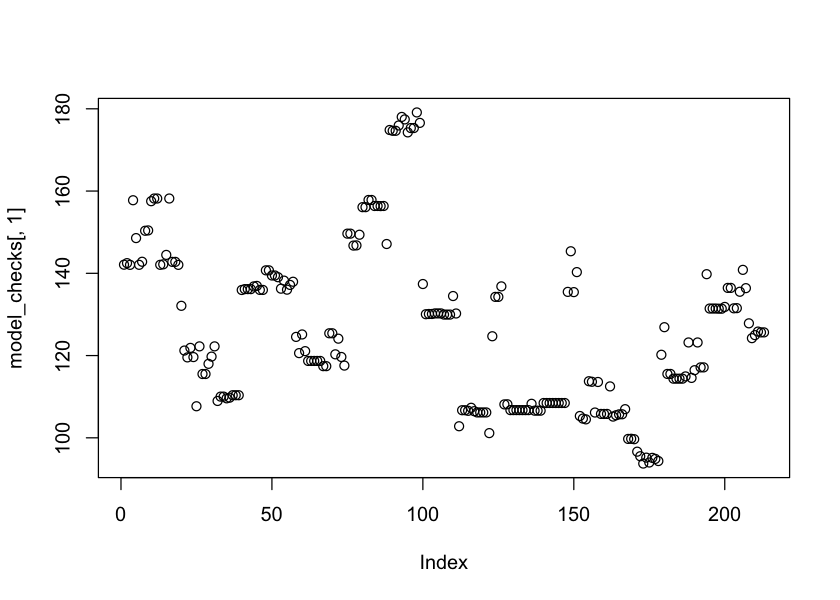

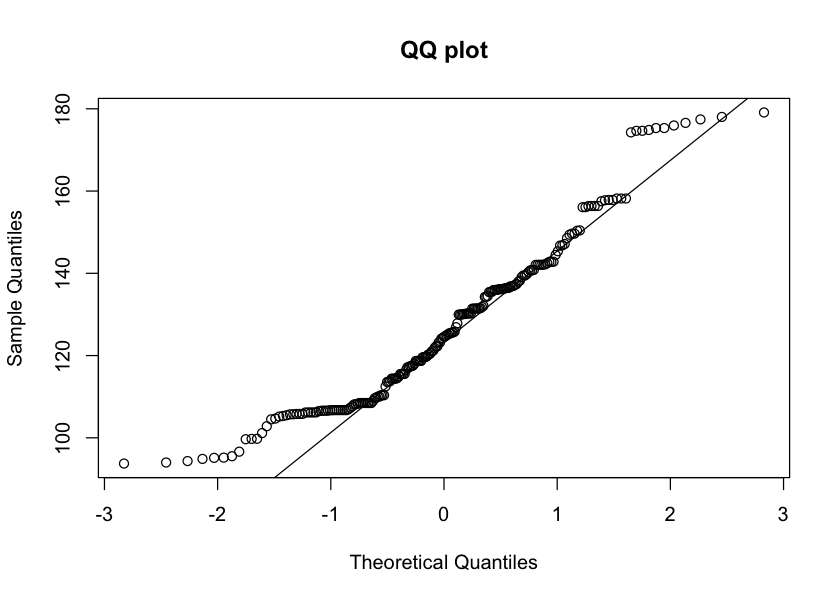

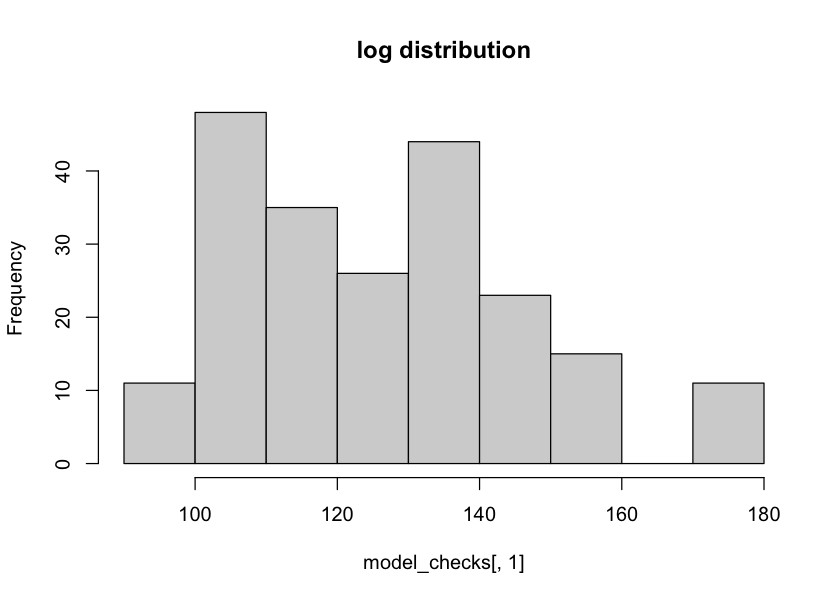

In [36]:
options(repr.plot.width=7, repr.plot.height=5)

model_checks <- fitted(bay_mod_FGB)
plot(model_checks[,1])
qqnorm(model_checks[,1], main="QQ plot")
qqline(model_checks[,1])
hist(model_checks[,1], main="log distribution")